# Exercise 6: Data Streams [100 pts]

## 1. Querying Users [30 pts]

Below is the code/psuedo code outline for the process. Since there are only 6000 messages, we will process all of them. We first receive all of them first and store them in a default dict. Then we classify them based on the frequency. The result should be a printed dictionary whose keys are the frequency: 1,2,etc. The values at each key should be the query itself, therefore categorizing them based on the number of times that query has been seen.

Similar to the slide referenced in the question, we will sample 1/10th of the stream as a subset. The code creates 10 hash buckets based on the user and the timestamp. This is so that each user is partitioned fully into a single bucket. Therefore, we can answer definitively if a specific user had repeated queries in a given day because all that user's queries will be in the same bucket. This will avoid storing partial data for the users and giving incorrect information about repeated queries. This could also be scaled up by using 100 buckets insteadf (since 10 buckets is 1/10th of the data as the sampling constraint found in the context slide). 

In [ ]:
from hashlib import md5
from collections import defaultdict

def hash_bucket(user, query, timestamp, num_buckets=10):
    # Optional: convert timestamp to day granularity
    day = timestamp.split("T")[0]  # '2025-04-05T13:55:00' -> '2025-04-05'
    key = f"{user}:{day}"  # sample by user per day
    bucket = int(md5(key.encode()).hexdigest(), 16) % num_buckets
    return bucket

# Storage for 1/10th of stream
stored_queries = defaultdict(lambda: defaultdict(int))  # user -> (query -> count)

# Simulated stream
for ev in dispatcher.launch():
    user = ev["user"]
    query = ev["msg"]
    timestamp = ev["timestamp"]

    if hash_bucket(user, query, timestamp) == 0:  # Keep only bucket 0
        stored_queries[(user, timestamp.split("T")[0])][query] += 1


To get information about the number of queries for a specific user, something along the lines of the following code would be run. Note: this is pseudo-code and an outline of a solution, not a fully working solution in spark. 

In [ ]:
for (user, day), queries in stored_queries.items():
    for query, count in queries.items():
        print(f"{user} ran query '{query}' {count} time(s) on {day}")

## 2. Bloom Filter [40 pts]

### [10 pts] Create a Bloom Filter, approximately 1000-2000 bits in size, for detecting bad words (i.e., AFINN of -4 or -5). It should be designed to run in Spark.

In [ ]:
import math
import mmh3 # Source: https://pypi.org/project/mmh3/
from bitarray import bitarray
import base64

class BloomFilter:
    def __init__(self, num_items, false_positive_prob):

        # Create a Bloom Filter approximately 1000-2000 bits in size
        self.size = 1500

        # Calculate optimal number of hash functions to use
        self.hash_count = self.det_optimal_hash_count(self.size, num_items)

        # Initialize bit array of all zeroes
        self.bit_array = bitarray(self.size)
        self.bit_array.setall(0)

        self.false_positive_prob = false_positive_prob  # false positive probability

    def add(self, item): ## Add item to the filter

        digests = []
        for i in range(self.hash_count):
            # Use i as a seed to generate different hash values for the same item.
            # The modulo operation (% self.size) maps the hash to a valid index.
            digest = mmh3.hash(item, i) % self.size
            digests.append(digest)

            # Mark the calculated position as True (1) in the bit array.
            self.bit_array[digest] = True

    def check(self, item):
        """Check for existence of an item in filter
        """
        for i in range(self.hash_count):

            # Calculate the same hash positions as done in add()
            digest = mmh3.hash(item, i) % self.size

            # If any bit is not set, the item definitely doesn't exist
            if self.bit_array[digest] == False:
                return False

        # If all bits were set, the item might exist
        return True

    def det_optimal_hash_count(self, m, n):
        """Calculates the optimal number of hash functions using k = (m/n) * lg(2)
        Source: https://en.wikipedia.org/wiki/Bloom_filter
        """
        k = (m/n) * math.log(2)
        return int(k)

    def get_bit_array(self):
        return self.bit_array

    def to_base64(self):
        """Convert bit array to Base64 string such that it can be placed in
        HDFS as a Base64-encoded text file and loaded into Spark from HDFS.
        """
        # Convert bitarray to bytes
        byte_array = self.bit_array.tobytes()

        # Convert bytes to Base64
        base64_str = base64.b64encode(byte_array).decode('utf-8')

        return base64_str

In [ ]:
# Load bad words
with open('bad_words.txt') as f:  # You said you have this list now
    bad_words = [line.strip().lower() for line in f if line.strip()]

# Build the Bloom Filter 
bloom = BloomFilter()
for word in bad_words:
    bloom.add(word)

# Save Filter as txt file to then be saved in hdfs
bitstring = bloom.to_base64()
with open('bloomfilter_base64.txt', 'w') as f:
    f.write(bitstring)

### [10 pts] The bit vector should be placed in HDFS  as a Base64-encoded text file and loaded into Spark from HDFS.

I ran the program and then the following command to put it in HDFS:

        hdfs dfs -put bloomfilter_base64.txt /user/brian_farrell/bloomfilter_base64.txt


Below is the code that I ran to get the list of -4 and -5 words from the AFINN list provided in the question. 

In [ ]:
import string

def get_afinn_bad_words(input_file, output_file):
    bad_words = set()
    with open(input_file, 'r') as file:
        for line in file:
            if not line.strip():
                continue
            parts = line.strip().split()
            if len(parts) == 2:
                word, score_str = parts
                try:
                    score = int(score_str)
                    if score in {-4, -5}:
                        # Remove punctuation from the word
                        word_clean = word.translate(str.maketrans('', '', string.punctuation))
                        bad_words.add(word_clean.lower())
                except ValueError:
                    continue

    # Write to file, one word per line
    with open(output_file, 'w') as out:
        for word in sorted(bad_words):
            out.write(f"{word}\n")

if __name__ == '__main__':
    afinn_path = 'AFINN.txt'  # this was run in same directory as the txt
    output_path = 'bad_words.txt'
    get_afinn_bad_words(afinn_path, output_path)
    print(f"Saved bad words to {output_path}")


### [15 pts] Integrate the Bloom Filter into Spark such that every arriving sentence is examined and passed along if none of the words in the sentence are bad words. Sentences that do contain bad words should be suppressed.

My implementation of combining the bloom filter with spark is below. 

In [ ]:
"""Quiz6Q2Listener.py"""

import sys, time

import pyspark
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

import math
import mmh3
from bitarray import bitarray
import base64

class BloomFilterShort:
    """A shortened version of the BloomFilter class from above.
       Can reconstruct the bit array from a Base64-encoded bit string.
    """
    def __init__(self, num_items, false_positive_prob):

        # Create a Bloom Filter approximately 1000-2000 bits in size
        self.size = 1500

        # Calculate optimal number of hash functions to use
        self.hash_count = self.det_optimal_hash_count(self.size, num_items)

        # Initialize bit array of all zeroes
        self.bit_array = bitarray(self.size)
        self.bit_array.setall(0)

        self.false_positive_prob = false_positive_prob  # false positive probability

    @classmethod
    def from_base64(cls, base64_str, num_items, false_positive_prob):
        """
        Create a bloom filter with a bit array that is encoded in a Base64 bit
        string.

        Parameters:
            base64_str : str
                The Base64-encoded bit string that the bit vector is encoded as.
            num_items : int
                Number of items expected to be stored in bloom filter
            false_positive_prob : float
                False Positive probability in decimal

        Returns:
            BloomFilter object with loaded bit array
        """

        # Create empty bloom filter
        bloom = cls(num_items, false_positive_prob)

        # Decode Base64 to bytes
        byte_array = base64.b64decode(base64_str.encode('utf-8'))

        # Convert bytes to bitarray
        bloom.bit_array = bitarray()
        bloom.bit_array.frombytes(byte_array)
        bloom.bit_array = bloom.bit_array[:1500]

        # Return the filter
        return bloom

    def check(self, item):
        #Check for existence of an item in the filter
        for i in range(self.hash_count):

            # Calculate the same hash positions as done in add()
            digest = mmh3.hash(item, i) % self.size

            # If any bit is not set, the item definitely doesn't exist
            if self.bit_array[digest] == False:
                return False

        # If all bits were set, the item might exist
        return True

    def det_optimal_hash_count(self, m, n):
        ##Same as from class above
        k = (m/n) * math.log(2)
        return int(k)

    def get_bit_array(self):
        return self.bit_array


def setLogLevel(sc, level):
    from pyspark.sql import SparkSession
    spark = SparkSession(sc)
    spark.sparkContext.setLogLevel(level)


if __name__ == "__main__":

    if len(sys.argv) != 3:
        print("Usage: bad_word_listener.py <hostname> <port>", file=sys.stderr)
        sys.exit(-1)

    print ('Argv', sys.argv)

    host = sys.argv[1]
    port = int(sys.argv[2])
    print ('host', type(host), host, 'port', type(port), port)

    sc_bak = SparkContext.getOrCreate()
    sc_bak.stop()

    time.sleep(15)
    print ('Ready to work!')

    ctx = pyspark.SparkContext(appName = "Netcat Wordcount", master="local[*]")
    print ('Context', ctx)

    spark = SparkSession(ctx).builder.getOrCreate()
    sc = spark.sparkContext

    setLogLevel(sc, "WARN")

    print ('Session:', spark)
    print ('SparkContext', sc)


    # Create DataFrame representing the stream of input lines from connection to host:port
    lines = spark\
        .readStream\
        .format('socket')\
        .option('host', host)\
        .option('port', port)\
        .load()

    # Read the Base64-encoded bit string from the Base64-encoded text file from HDFS and
    # broadcast it.
    file_df = spark.read.text('/user/brian_farrell/bloomfilter_base64.txt')
    base64_str = file_df.first()['value']
    broadcast_filter = spark.sparkContext.broadcast(base64_str)

    def check_line_for_bad_words(line):
        """Check if any of the words in a line are bad.
        """
        # Create Bloom filter with the bit array encoded in the broadcasted
        # Base64 string.
        bf = BloomFilterShort.from_base64(broadcast_filter.value,
                                            num_items=63,
                                            false_positive_prob=0.05)

        # Split the line into words
        words = line.split()

        # Return True if all words are good (no bad words found)
        return all(not bf.check(word) for word in words)

    # Register the user defined function
    is_clean_line = udf(check_line_for_bad_words, BooleanType())

    # Filter lines to only keep those without bad words
    clean_lines = lines.filter(is_clean_line(lines.value))

    # Start running the query that prints the clean lines to the console
    query = clean_lines\
        .writeStream\
        .outputMode('append')\
        .format('console')\
        .option("truncate", False)\
        .option("numRows", 100000)\
        .option("separator", "")\
        .option("header", False)\
        .start()

    query.awaitTermination()

Here is a link to my demo using the above code: [Demo](https://tufts.zoom.us/rec/share/PHLhSyKuWtj2wErp890cV_zZrr_phiRXFMEfZZcFedOjXkDBw3JCotma7a9h79aa.nn_9dtpICC560Wg_?startTime=1744123581000)

## 3. Counting Unique Users [30 pts]

### Modify read_stdin.py to implement the HyperLogLog algorithm. Increase the number of senders and decrease the (μ,σ) of the delay between queries until the receiver can no longer keep up! Draw a graph of the estimated number of users as a function of elapsed time.


The modified click-feeder.py program is below that significantly increases the users used to cause the std-in to not be able to keep up. After some testing, I decided to go with 6000 events, 3000 users, and 60 queries per user. I found these numbers showed the listener not being able to keep up with the sender, but also not too much data that the graph becomes unreadable. 

In [ ]:
#!/usr/bin/env python3

"""Ex6_Q3Sender.py"""

import importlib
import os
import sys

from click_gen import *
max_evs = 6000         # Total number of events that will be generated.
                       # If you want to make it run forever, set this number to like a million

n_senders = 3000          # Number of senders
n_queries = 60         # How many different queries (or messages) a sender can send

dispatcher = Dispatcher()
sender_names = shuffle(['sndr%04d' % i for i in range(n_senders)])

class Sender:
   senders = [dispatcher.add_sender(Sender(sender_name, n_queries, 2, 2)) for sender_name in sender_names]


for ev in dispatcher.launch():
    print(ev, flush=True)
    max_evs -= 1
    if max_evs == 0:
        break

Below is the modified read_stdin.py with the HyperLogLog algorithm.  

In [ ]:
"""Ex6_Q3Listener.py"""


import sys
import time
import math
import struct
from hashlib import sha1

# Predetermined threshold values for different precision values (p)
tresholdData = [ 10, 20, 40, 80, 220, 400, 900, 1800, 3100, 6500, 11500, 20000, 50000, 120000, 350000 ]

def bit_length(w):
    return w.bit_length()

def get_threshold(p):
    return tresholdData[p - 4]

def get_alpha(p):
    """Calculates the alpha parameter in the HyperLogLog algorithm. Alpha is a
    parameter for bias correction.
    https://medium.com/@meeusdylan/implementing-hyperloglog-in-go-ec88a3703a33
    """
    if not (4 <= p <= 16):
        raise ValueError("p=%d should be in range [4 : 16]" % p)

    if p == 4:
        return 0.673

    if p == 5:
        return 0.697

    if p == 6:
        return 0.709

    return 0.7213 / (1.0 + 1.079 / (1 << p))


def get_rho(w, max_width):
    rho = max_width - bit_length(w) + 1

    if rho <= 0:
        raise ValueError('w overflow')

    return rho


class HyperLogLog:

    ## Source for HLL: https://en.wikipedia.org/wiki/HyperLogLog

    __slots__ = ('alpha', 'p', 'm', 'M')

    def __init__(self, error_rate):
        """
        Initialize HyperLogLog with the given error rate

            error_rate: float
                Desired error rate (between 0 and 1)
        """

        if not (0 < error_rate < 1):
            raise ValueError("Error_Rate must be between 0 and 1.")

        # Calculate precision (p) based on desired error rate
        # error_rate = 1.04 / sqrt(m) where m = 2^p
        p = int(math.ceil(math.log((1.04 / error_rate) ** 2, 2)))

        self.alpha = get_alpha(p) # param for bias correction
        self.p = p # precision
        self.m = 1 << p
        self.M = [ 0 for i in range(self.m) ]

    def add(self, value):
        #Add item to the HyperLogLog

        # Convert input to bytes for hashing
        if isinstance(value, str):
            value = value.encode('utf-8')  # Encode strings (Unicode) to bytes
        elif not isinstance(value, bytes):
            value = bytes(value)

        x = struct.unpack('!Q', sha1(value).digest()[:8])[0]

        # Use first p bits for register index
        j = x & (self.m - 1)

        # Use remaining bits for the value
        w = x >> self.p

        # Update register with max value of current or new rho
        self.M[j] = max(self.M[j], get_rho(w, 64 - self.p))

    def update(self, *others):
        """ Merge multiple HyperLogLog counters. Takes maximum value for each
        register position.
        """

        for item in others:
            if self.m != item.m:
                raise ValueError('Counters precisions should be equal')

        self.M = [max(*items) for items in zip(*([ item.M for item in others ] + [ self.M ]))]

    def card(self):
        ##stimate cardinality using HyperLogLog algorithm

        # count number of registers equal to 0
        V = self.M.count(0)

        H = self.m * math.log(self.m / float(V))
        return H


def process_stream():
    """Process input stream and estimate unique senders"""
    hll = HyperLogLog(0.01) # Initialize with 1% error rate
    count = 0
    start_time = time.time()
    last_print_time = start_time

    print("Starting HyperLogLog stream processing for unique senders...")
    print("Estimates will be printed every 50 events")

    try:
        while True:
            line = sys.stdin.readline()
            if not line:
                break

            sender_and_query = line.split('sender ')[1:]
            sender_and_query = sender_and_query[0].split('said:')
            sender = sender_and_query[0].strip()

            # Only add sender to HLL
            hll.add(sender)

            count += 1
            current_time = time.time()

            if count % 50 == 0:
                elapsed_time = current_time - start_time
                rate = count / elapsed_time
                unique_senders = hll.card()

                print("\n=== HyperLogLog Statistics ===")
                print(f"Events processed: {count:,}")
                print(f"Estimated unique senders: {unique_senders:,}")
                print(f"Processing rate: {rate} events/second")
                print(f"Elapsed time: {elapsed_time} seconds")
                print("============================\n")

    except KeyboardInterrupt:
        final_time = time.time()
        elapsed_time = final_time - start_time
        rate = count / elapsed_time

        print("\n=== Final Statistics ===")
        print(f"Total events processed: {count:,}")
        print(f"Final estimate of unique senders: {hll.card():,}")
        print(f"Average processing rate: {rate:.2f} events/second")
        print(f"Total runtime: {elapsed_time:.2f} seconds")
        print("=====================")

# if __name__ == "__main__":
#     process_stream()

The two commands I used to run the listener and the sender are below:

        nc -lk localhost 9999 | python3 Ex6_Q3Listener.py
        python3 Ex6_Q3Sender.py 2> /dev/null | nc localhost 9999

I used the following code below to graph the results

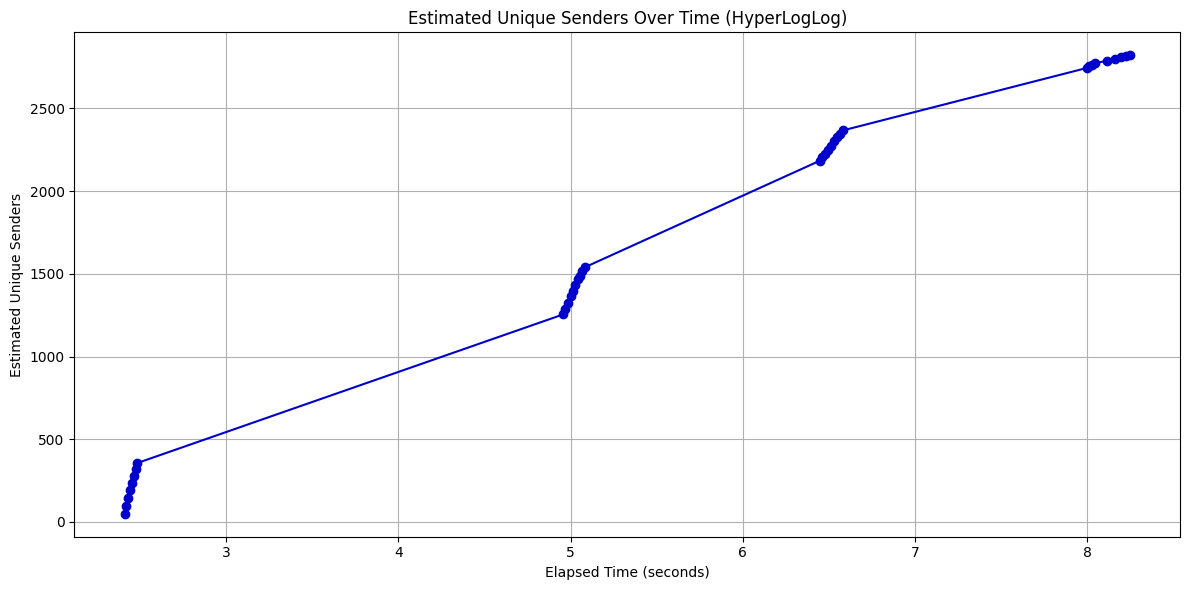

In [1]:
import matplotlib.pyplot as plt

# Elapsed time (seconds)
elapsed_time = [
    2.411, 2.421, 2.431, 2.442, 2.453, 2.463, 2.474, 2.484,
    4.958, 4.970, 4.988, 5.002, 5.014, 5.028, 5.043, 5.055, 5.069, 5.084,
    6.446, 6.462, 6.478, 6.495, 6.513, 6.531, 6.545, 6.563, 6.581,
    7.997, 8.013, 8.027, 8.045, 8.117, 8.159, 8.194, 8.226, 8.247
]

# Estimated unique senders
estimated_unique_senders = [
    49.07, 98.29, 145.65, 190.10, 234.67, 278.35, 318.07, 355.84,
    1254.85, 1289.43, 1320.84, 1364.25, 1393.63, 1430.69, 1466.74, 1489.72, 1517.12, 1540.18,
    2183.21, 2203.79, 2225.54, 2249.61, 2273.72, 2300.16, 2325.50, 2346.26, 2367.04,
    2744.56, 2758.76, 2763.49, 2774.15, 2788.37, 2799.04, 2812.09, 2815.66, 2821.60
]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(elapsed_time, estimated_unique_senders, marker='o', linestyle='-', color='mediumblue')
plt.title('Estimated Unique Senders Over Time (HyperLogLog)')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Estimated Unique Senders')
plt.grid(True)
plt.tight_layout()
plt.show()


The graph showing the output is above. Due to the large amount of data, I only included segments of the full output in the code above to create the graph. However, you can still see clearly that the listener struggles to keep up with the sender. There are 3000 users, but the listener is never able to detect that. It gets close, with the final estimation being 2,870 users, but it is never able to fully catch up before the end of the 6000 events. Some of the shortened output is also pasted below.

Shortened Output: 

                Brians-MacBook-Pro:Week 8 brianfarrell$ nc -lk localhost 9999 | python3 Q3Listener.py
                Starting HyperLogLog stream processing for unique senders...
                Estimates will be printed every 50 events

                === HyperLogLog Statistics ===
                Events processed: 50
                Estimated unique senders: 49.073419125781754
                Processing rate: 18.806861522838233 events/second
                Elapsed time: 2.658604145050049 seconds
                ============================


                === HyperLogLog Statistics ===
                Events processed: 100
                Estimated unique senders: 98.29426482639066
                Processing rate: 37.46461708201977 events/second
                Elapsed time: 2.669185161590576 seconds
                ============================


                === HyperLogLog Statistics ===
                Events processed: 150
                Estimated unique senders: 145.64544305801925
                Processing rate: 55.97338454291049 events/second
                Elapsed time: 2.679845094680786 seconds
                ============================


                === HyperLogLog Statistics ===
                Events processed: 200
                Estimated unique senders: 190.09857509465706
                Processing rate: 74.3523074268122 events/second
                Elapsed time: 2.68989634513855 seconds
                ============================


                === HyperLogLog Statistics ===
                Events processed: 250
                Estimated unique senders: 234.67264574621527
                Processing rate: 92.56142552448114 events/second
                Elapsed time: 2.70090913772583 seconds
                ============================


                === HyperLogLog Statistics ===
                Events processed: 300
                Estimated unique senders: 278.35114893950345
                Processing rate: 110.64581449360391 events/second
                Elapsed time: 2.7113542556762695 seconds
                ============================


                === HyperLogLog Statistics ===
                Events processed: 350
                Estimated unique senders: 318.0674874979323
                Processing rate: 128.57105196849042 events/second
                Elapsed time: 2.7222301959991455 seconds
                ============================


                === HyperLogLog Statistics ===
                Events processed: 400
                Estimated unique senders: 355.8362964728693
                Processing rate: 146.29127572162864 events/second
                Elapsed time: 2.7342710494995117 seconds
                ============================

                ...
                ...
                === HyperLogLog Statistics ===
                Events processed: 5,850
                Estimated unique senders: 2,848.941021509419
                Processing rate: 707.4275358035911 events/second
                Elapsed time: 8.269398212432861 seconds
                ============================


                === HyperLogLog Statistics ===
                Events processed: 5,900
                Estimated unique senders: 2,856.0820938293555
                Processing rate: 712.1925710914219 events/second
                Elapsed time: 8.284276247024536 seconds
                ============================


                === HyperLogLog Statistics ===
                Events processed: 5,950
                Estimated unique senders: 2,863.226279989063
                Processing rate: 716.8954391762575 events/second
                Elapsed time: 8.299676179885864 seconds
                ============================


                === HyperLogLog Statistics ===
                Events processed: 6,000
                Estimated unique senders: 2,870.3735827052897
                Processing rate: 721.5498331329078 events/second
                Elapsed time: 8.315433979034424 seconds
                ============================

                ^C
                === Final Statistics ===
                Total events processed: 6,000
                Final estimate of unique senders: 2,870.3735827052897
                Average processing rate: 363.71 events/second
                Total runtime: 16.50 seconds
                =====================